# GRN between Cell Types

This Notebook is part of the Bachelorthese from David Wild.

The goal of this notebook is to find out gene-gene interactions between different cell types. We want as a result a GRN that not only describes which genes express which, but also how much (weighted graph) and in which direction (exhibiting, inhibiting).  
Another aspect that would be interesting are finding co-factors.


In [1]:
try:
    # Check if this gets executed in google colab. 
    # If so, then we need to install pip packages and clone the repo and data
    import google.colab
    IN_COLAB = True
except ImportError:
    IN_COLAB = False

In [2]:
if IN_COLAB:
    !pip install scanpy
    !pip install torch
    !pip install matplotlib
    !pip install pandas
    !pip install numpy
    !pip install -U -q PyDrive
else:
    !pip install -r requirements.txt

/bin/bash: /home/atr0x/Documents/UNI/WS2025/BachelorArbeit/GAE-gene-interactions/.venv/bin/pip: /home/atr0x/Documents/UNI/WS2025/BachelorArbeit/GAE-gene-interactions/venv/bin/python3.10: bad interpreter: No such file or directory


In [3]:
if IN_COLAB:
    !git clone https://github.com/DavidWild02/BachelorThesis-ML-Gene-Interactions.git
    %cd ./BachelorThesis-ML-Gene-Interactions

In [4]:
if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')
    !cp -r /content/drive/MyDrive/DavidWildBachelorthesis/data .

In [5]:
import scanpy as sc
import pandas as pd
import numpy as np

adata = sc.read_h5ad("./data/subdom_processed.h5ad")
adata

AnnData object with n_obs × n_vars = 2671 × 13144
    obs: 'n_genes_by_counts', 'total_counts', 'clusters', 'ct_num_exp_genes', 'ct_score', 'ct_pseudotime'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std', 'ct_gene_corr', 'ct_correlates'
    uns: 'clusters_colors', 'clusters_sizes', 'ct_params', 'hvg', 'leiden', 'log1p', 'neighbors', 'paga', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'Ms', 'Mu', 'log_tpm', 'spliced', 'tpm', 'unspliced'
    obsp: 'connectivities', 'distances'

In [6]:
adata.to_df().head()

,SUB2.g1,SUB2.g2,SUB2.g3,SUB2.g4,SUB2.g5,SUB2.g6,SUB2.g7,SUB2.g8,SUB2.g9,SUB2.g10,...,SUB2.g13135,SUB2.g13136,SUB2.g13137,SUB2.g13138,SUB2.g13139,SUB2.g13140,SUB2.g13141,SUB2.g13142,SUB2.g13143,SUB2.g13144
AAACCCAAGGACAGCT-1,0.009687,-1.032545,-1.566363,1.018223,-0.933981,-0.410398,-0.349553,-0.444472,-0.132447,-0.567418,...,0.0,0.0,0.0,-0.293056,0.0,0.0,0.0,0.0,-0.365098,-0.652811
AAACCCAAGGGTTTCT-1,1.598354,-0.300789,-0.202161,-0.002592,0.181964,0.269252,-0.393041,0.037609,0.115123,-0.754939,...,0.0,0.0,0.0,-0.192047,0.0,0.0,0.0,0.0,-0.296943,-0.677305
AAACCCACAAATGGTA-1,-0.777102,-0.792809,-1.281675,1.262175,-0.185155,-0.726397,-0.455605,-0.671795,-0.448440,-0.868259,...,0.0,0.0,0.0,-0.315716,0.0,0.0,0.0,0.0,-0.205751,0.327006
AAACCCATCGAGAAGC-1,0.696619,-0.306533,0.700373,-1.587061,-0.054666,0.263420,-0.105024,0.250046,0.661372,-0.186924,...,0.0,0.0,0.0,-0.300775,0.0,0.0,0.0,0.0,-0.310817,-0.878208
AAACCCATCTTGTTAC-1,-1.319795,-1.191836,-1.658409,1.626106,-0.142163,-1.176196,-0.391015,-0.537126,-0.254368,-0.777899,...,0.0,0.0,0.0,-0.301799,0.0,0.0,0.0,0.0,-0.303617,-0.420889


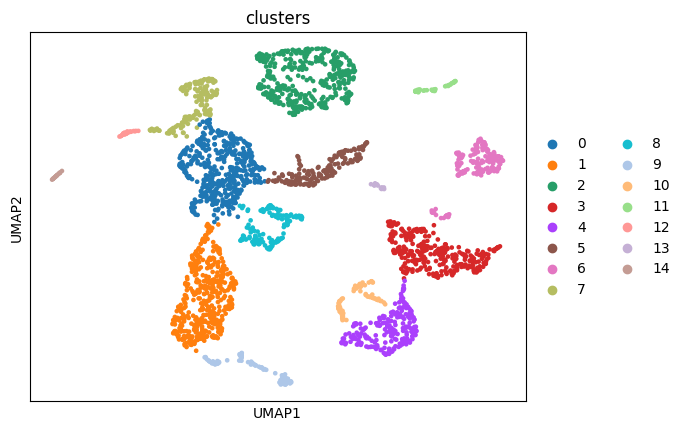

In [7]:
sc.pl.umap(adata, color="clusters")

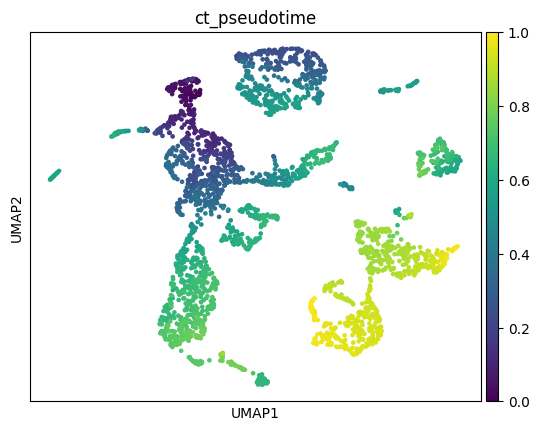

In [8]:
sc.pl.umap(adata, color="ct_pseudotime")

In the data set the data is already preprocessed, clustered and also the pseudo-time was calculated on it. The pseudo-time is a time approximation, measured on how specified the cell is in terms of how many genes are expressed. The idea is that more specialized cells have fewer expressed genes.

We already have a GRN, but it is global, we would prefer a single GRN for each cell-type to cell-type transition. Also we want a weighted GRN and the GRN at the moment is a binary matrix.
One method to construct such GRNs is by just using a Masked Linear Regression. The weight matrix of this linear regression would then be the adjacency matrix of the GRN.

To look if the approach is feasible at all, we will first only do that for stem cells (cluster 7) to transition cells (cluster 0).  
After that we validate how well prediction is (accuracy, residual plot) and how well the GRN correlates to existing knowledge.
Also how non linear models like Neural networks perform in comparison.

In [9]:
from IPython.display import display

#  load data global GRN
df_grn = pd.read_csv("./data/transcription_factor_adjacency_matrix.csv", index_col="gene_ids")
print("transcription factor adjacency matrix")
df_grn = df_grn.transpose()
display(df_grn.head())

transcription factor adjacency matrix


gene_ids,SUB2.g1,SUB2.g2,SUB2.g11,SUB2.g16,SUB2.g18,SUB2.g21,SUB2.g22,SUB2.g26,SUB2.g27,SUB2.g31,...,SUB2.g12978,SUB2.g12979,SUB2.g12980,SUB2.g13052,SUB2.g13056,SUB2.g13090,SUB2.g13093,SUB2.g13119,SUB2.g13123,SUB2.g13134
SUB2.g8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
SUB2.g231,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,1,1,0,0,0,0
SUB2.g755,0,0,1,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
SUB2.g902,1,1,1,0,0,0,0,0,0,0,...,0,0,1,1,1,0,0,0,0,0
SUB2.g924,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,1,1,1


The Linear Regression should take samples from cluster A and predict samples in cluster B. The mappings a->b are sampled randomly.  
Of course this approach could be enhanced with other techniques, that search for a better mapping. Like Optimal Transport for example.

In [10]:
from typing import Iterator, Tuple
from torch.utils.data import Sampler

np.random.seed(42) # set seed to make reproducible outputs

# TODO: let this inherit from torch.Sampler
class RandomMappingSampler(Sampler):
    def __init__(self, data_A: np.ndarray, data_B: np.ndarray):
        self._data_A = data_A
        self._data_B = data_B
        super().__init__()

    def __iter__(self) -> Iterator[Tuple[int, int]]:
        while True:
            index_A = np.random.randint(0, self._data_A.shape[0])
            index_B = np.random.randint(0, self._data_B.shape[0])
            # a sampler should just return the indices and not the samples
            yield index_A, index_B



In [11]:
from itertools import islice
from MaskedRidgeRegressor import MaskedRidgeRegressor

def create_grn_for_cluster_to_cluster_association(samples_cluster_a: np.ndarray, samples_cluster_b: np.ndarray, mask_grn: np.ndarray, num_samples=1000):
    sampler = RandomMappingSampler(samples_cluster_a, samples_cluster_b)
    sample_indices = list(islice(iter(sampler), num_samples))
    sample_indices_a = list(map(lambda x: x[0], sample_indices))
    sample_indices_b = list(map(lambda x: x[1], sample_indices))

    X = samples_cluster_a[sample_indices_a]
    y = samples_cluster_b[sample_indices_b]

    model = MaskedRidgeRegressor(mask_grn)
    model.fit(X, y)

    return model.W_


In [12]:
stem_cells_cluster_id = '7'
transition_cells_cluster_id = '0'

obs_mask_stem_cells = adata.obs["clusters"].values == stem_cells_cluster_id
stem_cells_cluster = adata.X[obs_mask_stem_cells, :]
df_stem_cells = pd.DataFrame(stem_cells_cluster,
                                     index=adata.obs_names[obs_mask_stem_cells],
                                     columns=adata.var_names)

obs_mask_transition_cells = adata.obs["clusters"].values == transition_cells_cluster_id
transition_cell_cluster = adata.X[obs_mask_transition_cells, :]
df_transition_cells = pd.DataFrame(transition_cell_cluster,
                                     index=adata.obs_names[obs_mask_transition_cells],
                                     columns=adata.var_names)

print(f"Number of stem cells: {df_stem_cells.shape[0]}")
print(f"Number of transition cells: {df_transition_cells.shape[0]}")

Number of stem cells: 151
Number of transition cells: 453


In [14]:

grn_mask = df_grn.values
stem_cells_cluster = df_stem_cells[df_grn.index].values
transition_cell_cluster = df_transition_cells[df_grn.columns].values
weighted_grn = create_grn_for_cluster_to_cluster_association(stem_cells_cluster, transition_cell_cluster, grn_mask)
df_weighted_grn = pd.DataFrame(weighted_grn, index=df_grn.index, columns=df_grn.columns)
df_weighted_grn.head()

Epoch 0:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 999: 100%|██████████| 1000/1000 [00:28<00:00, 34.57it/s, loss=0.517]


gene_ids,SUB2.g1,SUB2.g2,SUB2.g11,SUB2.g16,SUB2.g18,SUB2.g21,SUB2.g22,SUB2.g26,SUB2.g27,SUB2.g31,...,SUB2.g12978,SUB2.g12979,SUB2.g12980,SUB2.g13052,SUB2.g13056,SUB2.g13090,SUB2.g13093,SUB2.g13119,SUB2.g13123,SUB2.g13134
SUB2.g8,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,-0.0,-0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
SUB2.g231,0.000000,0.000000,0.000000,0.0,0.0,0.443906,0.0,0.0,-0.0,0.0,...,0.0,0.0,0.000000,0.000000,-0.258134,0.062610,0.0,-0.000000,0.000000,-0.000000
SUB2.g755,0.000000,0.000000,0.269529,-0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,-0.042575,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
SUB2.g902,-0.340518,0.132702,0.077156,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,-0.148608,0.100157,0.404469,0.000000,0.0,0.000000,0.000000,-0.000000
SUB2.g924,0.000000,0.000000,0.384706,-0.0,0.0,0.000000,0.0,-0.0,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.000000,-0.072527,0.0,0.015256,0.319251,0.274037
